I have simulated $100\,000$ games with four `RandomBot` players to generate a dataset.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [5]:
base_dir = os.path.join("..", "game_logs")

tournament_path = os.path.join(base_dir, "GameLogs.csv")

logs = pd.read_csv(tournament_path)
logs.head()

,game_id,round_id,action_type,active_player,bet_type,camel,camel_c_0_location,camel_c_0_stack_location,camel_c_0_yet_to_move,camel_c_1_location,...,player_1_trap_location,player_1_trap_type,player_2_coins,player_2_trap_location,player_2_trap_type,player_3_coins,player_3_trap_location,player_3_trap_type,trap_location,trap_type
0,0,0,NaN,NaN,NaN,NaN,0,0,True,2,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
1,0,1,move_camel,0.0,NaN,c_3,0,0,True,4,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
2,0,2,round_winner_bet,1.0,NaN,c_1,0,0,True,4,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
3,0,3,game_bet,2.0,win,c_0,0,0,True,4,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
4,0,4,move_trap,3.0,NaN,NaN,0,0,True,4,...,NaN,NaN,2,NaN,NaN,2,15.0,1.0,15.0,1.0


I'm interested in only the first and last entry of each game, i.e the starting and ending positions of the camels, respectively.

In [6]:
game_starts = logs.sort_values(["game_id", "round_id"]).groupby("game_id").nth(0)
game_ends = logs.sort_values(["game_id", "round_id"]).groupby("game_id").nth(-1)

In [7]:
game_starts.head()

,game_id,round_id,action_type,active_player,bet_type,camel,camel_c_0_location,camel_c_0_stack_location,camel_c_0_yet_to_move,camel_c_1_location,...,player_1_trap_location,player_1_trap_type,player_2_coins,player_2_trap_location,player_2_trap_type,player_3_coins,player_3_trap_location,player_3_trap_type,trap_location,trap_type
0,0,0,NaN,NaN,NaN,NaN,0,0,True,2,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN


In [8]:
game_ends[['player_0_coins', 'player_1_coins', 'player_2_coins', 'player_3_coins']].head()

,player_0_coins,player_1_coins,player_2_coins,player_3_coins
37,12,29,0,-1


Because camel positions consist of both track and stack positions, I will create a new value for the camel position, defined as:

$$ P = 10 \cdot pos_{track} + pos_{stack} $$

This ensures that camels stacked on top of each other will be treated accordingly.

In [9]:
def get_camel_pos(camel_id, dat):
    track_loc = "camel_" + camel_id + "_location"
    stack_loc = "camel_" + camel_id + "_stack_location"
    return dat[track_loc] * 10 + dat[stack_loc] 

In [10]:
start_positions = pd.DataFrame({
    camel_id: get_camel_pos(camel_id, game_starts) for
    camel_id in ["c_1", "c_2", "c_3", "c_4"]})

end_positions = pd.DataFrame({
    camel_id: get_camel_pos(camel_id, game_ends) for
    camel_id in ["c_1", "c_2", "c_3", "c_4"]})

In [11]:
start_positions.head()

,c_1,c_2,c_3,c_4
0,21,10,20,11


In [12]:
end_positions.head()

,c_1,c_2,c_3,c_4
37,90,50,160,110


The camels' relative places for each game can be obtained with `numpy.argsort`. It needs to be called twice as `argsort` returns the indices with which an array would be sorted, e.g. the $3^{rd}$ value of `np.argsort(x)` indicates the $3^{rd}$ largest value in the original array $x$. Therefore, $np.argsort(np.argsort(x))$ describes the order of each of the values in the original array $x$. 

In [13]:
start_positions_index = start_positions.apply(lambda x: np.argsort(np.argsort(-x)) + 1, axis=1)
start_positions_index.head()

,c_1,c_2,c_3,c_4
0,1,4,2,3


In [14]:
end_positions_index = end_positions.apply(lambda x: np.argsort(np.argsort(-x)) + 1, axis=1)
end_positions_index.head()

,c_1,c_2,c_3,c_4
37,3,4,1,2


For each of the camels, I can now look at the co-occurrence of positions, i.e. how often does a camel start at position $i$ and end at position $j$?

Because all camels in this analysis are identical, their respective co-occurrence matrices can simply be added together.

In [15]:
def get_cooccurrence_matrix(camel_id):
    return pd.crosstab(
        index=start_positions_index[camel_id].values, 
        columns=end_positions_index[camel_id].values)

camel_pos = get_cooccurrence_matrix("c_1") + \
    get_cooccurrence_matrix("c_2") + \
    get_cooccurrence_matrix("c_3") + \
    get_cooccurrence_matrix("c_4")

camel_pos.columns.name = "End"
camel_pos.index.name = "Start"

camel_pos

End,1,2,3,4
Start,,,,
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


The result is the following heatmap. Camels that begin in first place have a tendency to 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


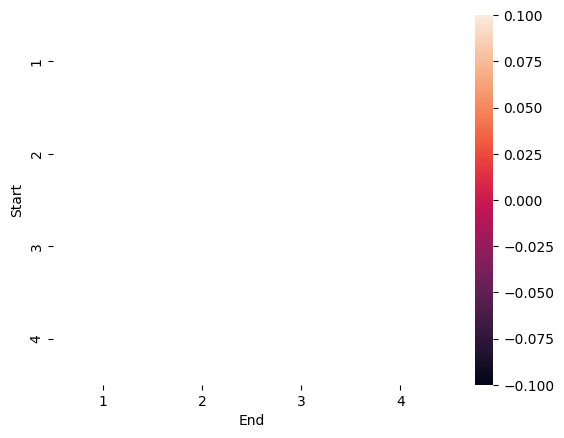

In [16]:
sns.heatmap(camel_pos, annot=True, fmt="g");

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: xlabel='End', ylabel='Start'>

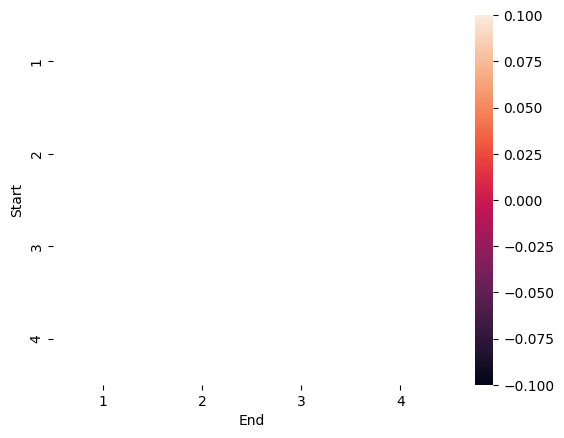

In [17]:
# Normalize by column
camel_pos_normalized = camel_pos.div(camel_pos.sum(axis=0), axis=1)

# Plot the normalized heatmap
sns.heatmap(camel_pos_normalized, annot=True, fmt=".2f")